### Calculating the RMSE and COrelation R for weather data.
### Open_meteo API is used.

In [1]:
## the Function is take from this source.
#https://open-meteo.com/en/docs/historical-weather-api#start_date=1950-01-01&end_date=2023-12-31&hourly=&daily=temperature_2m_mean&timezone=Europe%2FBerlin&models=era5_seamless

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import openmeteo_requests
import requests_cache
from retry_requests import retry
from sklearn.metrics import mean_squared_error, r2_score
import xarray as xr


In [64]:
Dwd_daily = pd.read_csv(r'taglich.csv',sep= ';')
Dwd_50_year_data = pd.read_csv(r'50_years_data.csv',sep= ';')

In [65]:
Dwd_daily.head()

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
0,722,20230526,10,12.3,6.5,9,0.0,0,14.8,0,1.4,7.5,895.1,7.0,76.0,10.8,3.4,1.0,eor
1,722,20230527,10,9.2,5.2,9,0.0,0,14.9,0,0.3,7.6,894.0,7.8,72.0,11.6,2.9,1.2,eor
2,722,20230528,10,11.7,5.3,9,0.0,0,15.2,0,1.0,7.4,890.3,10.7,57.0,13.8,7.5,4.6,eor
3,722,20230529,10,13.4,6.7,9,0.0,0,13.2,0,5.3,8.3,891.2,8.4,75.0,11.5,4.0,2.9,eor
4,722,20230530,10,12.8,7.3,9,0.0,0,15.0,0,3.8,7.7,893.0,7.8,72.0,10.2,3.9,1.8,eor


In [66]:
Dwd_50_year_data.head()

,STATIONS_ID,MESS_DATUM,QN_3,FX,FM,QN_4,RSK,RSKF,SDK,SHK_TAG,NM,VPM,PM,TMK,UPM,TXK,TNK,TGK,eor
0,722,18960101,-999,-999.0,-999.0,1,0.0,0,-999.0,70,2.3,2.5,887.5,-6.7,69.0,-5.3,-9.6,-999.0,eor
1,722,18960102,-999,-999.0,-999.0,1,2.1,-999,-999.0,65,4.7,3.9,887.7,-2.2,77.0,-0.7,-6.0,-999.0,eor
2,722,18960103,-999,-999.0,-999.0,1,1.8,-999,-999.0,60,8.0,6.0,886.5,0.1,100.0,1.1,-2.0,-999.0,eor
3,722,18960104,-999,-999.0,-999.0,1,0.9,-999,-999.0,60,2.7,4.0,889.7,-4.0,92.0,-0.3,-5.6,-999.0,eor
4,722,18960105,-999,-999.0,-999.0,1,0.0,0,-999.0,60,2.7,4.3,896.1,-3.2,89.0,-2.8,-4.6,-999.0,eor


In [67]:
drop = ['QN_3','QN_4',' SDK','SHK_TAG', '  NM', ' VPM', '  PM', ' UPM', ' TNK', ' TGK', 'eor', ' TXK','STATIONS_ID']
Dwd_daily.drop(columns=drop,inplace=True)
Dwd_50_year_data.drop(columns=drop,inplace=True)

In [68]:
new_column = {'MESS_DATUM':'date','  FX':'Maximum wind peak ','  FM':'Daily average wind speed m/s',' RSK':'daily rainfall','RSKF':'daily form of precipitation',' TMK':'Daily average temperature',}

In [69]:
Dwd_daily.rename(columns=new_column, inplace=True)
print(Dwd_daily)

         date  Maximum wind peak   Daily average wind speed m/s  \
0    20230526                12.3                           6.5   
1    20230527                 9.2                           5.2   
2    20230528                11.7                           5.3   
3    20230529                13.4                           6.7   
4    20230530                12.8                           7.3   
..        ...                 ...                           ...   
545  20241121                21.1                          13.6   
546  20241122                29.1                          15.7   
547  20241123              -999.0                          17.7   
548  20241124                43.7                          26.0   
549  20241125                43.1                          22.2   

     daily rainfall  daily form of precipitation  Daily average temperature  
0               0.0                            0                        7.0  
1               0.0                    

In [70]:
# Convert MESS_DATUM to datetime
Dwd_daily['date'] = pd.to_datetime(Dwd_daily['date'], format='%Y%m%d')

In [71]:
Dwd_daily

,date,Maximum wind peak,Daily average wind speed m/s,daily rainfall,daily form of precipitation,Daily average temperature
0,2023-05-26,12.3,6.5,0.0,0,7.0
1,2023-05-27,9.2,5.2,0.0,0,7.8
2,2023-05-28,11.7,5.3,0.0,0,10.7
3,2023-05-29,13.4,6.7,0.0,0,8.4
4,2023-05-30,12.8,7.3,0.0,0,7.8
...,...,...,...,...,...,...
545,2024-11-21,21.1,13.6,1.0,7,-6.5
546,2024-11-22,29.1,15.7,4.8,7,-5.9
547,2024-11-23,-999.0,17.7,6.3,8,-4.5
548,2024-11-24,43.7,26.0,0.0,4,4.2


In [72]:
#converting them to numeric
Dwd_daily.apply(pd.to_numeric)
Dwd_daily.replace(to_replace= -999.0, value=0,inplace=True)
Dwd_daily

,date,Maximum wind peak,Daily average wind speed m/s,daily rainfall,daily form of precipitation,Daily average temperature
0,2023-05-26,12.3,6.5,0.0,0,7.0
1,2023-05-27,9.2,5.2,0.0,0,7.8
2,2023-05-28,11.7,5.3,0.0,0,10.7
3,2023-05-29,13.4,6.7,0.0,0,8.4
4,2023-05-30,12.8,7.3,0.0,0,7.8
...,...,...,...,...,...,...
545,2024-11-21,21.1,13.6,1.0,7,-6.5
546,2024-11-22,29.1,15.7,4.8,7,-5.9
547,2024-11-23,0.0,17.7,6.3,8,-4.5
548,2024-11-24,43.7,26.0,0.0,4,4.2


In [73]:
Dwd_50_year_data.rename(columns=new_column, inplace=True)
Dwd_50_year_data['date'] = pd.to_datetime(Dwd_50_year_data['date'], format='%Y%m%d')
Dwd_50_year_data.apply(pd.to_numeric)
Dwd_50_year_data.replace(to_replace= -999.0, value=0,inplace=True)
Dwd_50_year_data.replace(to_replace= -999, value=0,inplace=True)
Dwd_50_year_data.set_index('date',inplace=True)
Dwd_50_year_data


,Maximum wind peak,Daily average wind speed m/s,daily rainfall,daily form of precipitation,Daily average temperature
date,,,,,
1896-01-01,0.0,0.0,0.0,0,-6.7
1896-01-02,0.0,0.0,2.1,0,-2.2
1896-01-03,0.0,0.0,1.8,0,0.1
1896-01-04,0.0,0.0,0.9,0,-4.0
1896-01-05,0.0,0.0,0.0,0,-3.2
...,...,...,...,...,...
2023-12-27,32.5,13.7,1.4,8,-1.2
2023-12-28,33.0,22.6,1.3,8,0.8
2023-12-29,36.9,22.9,21.7,4,1.2


In [ ]:
null_value = Dwd_50_year_data.isna().sum()
null_value 

Maximum wind peak               0
Daily average wind speed m/s    0
daily rainfall                  0
daily form of precipitation     0
Daily average temperature       0
dtype: int64

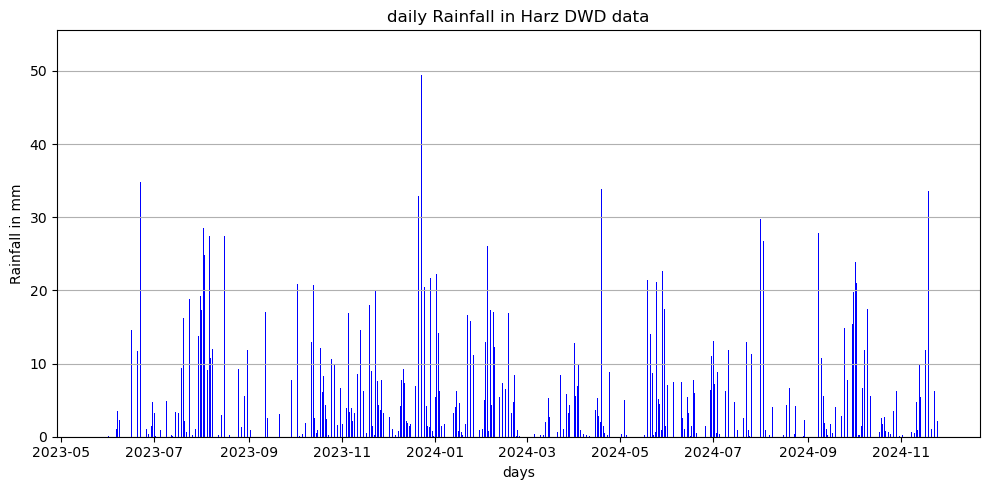

In [76]:
plt.figure(figsize=(10, 5))
plt.bar(Dwd_daily['date'], Dwd_daily['daily rainfall'], width=0.5, color='blue')
plt.title('daily Rainfall in Harz DWD data')
plt.xlabel('days')
plt.ylabel('Rainfall in mm')
plt.grid(axis='y')
plt.tight_layout()

In [ ]:
#Rainfall data by open meto

#Calling API

# Setup the Open-Meteo API client with cache and retry on error
cache_session = requests_cache.CachedSession('.cache', expire_after = 3600)
retry_session = retry(cache_session, retries = 5, backoff_factor = 0.2)
openmeteo = openmeteo_requests.Client(session = retry_session)

# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
# the Function is take from this source.
#https://open-meteo.com/en/docs/historical-weather-api#start_date=1950-01-01&end_date=2023-12-31&hourly=&daily=temperature_2m_mean&timezone=Europe%2FBerlin&models=era5_seamless
url = "https://climate-api.open-meteo.com/v1/climate"
params = {
	"latitude": [51.48],
	"longitude": [10.37],
	"start_date": "2023-05-26",
	"end_date": "2024-11-25",
	"models": "EC_Earth3P_HR",
	"timezone": "Europe/Berlin",
	"disable_bias_correction": "true",
	"daily": "rain_sum"
}
responses = openmeteo.weather_api(url, params=params)


In [78]:
dataframe = {}

# Process first location. Add a for-loop for multiple locations or weather models

response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_rain_sum = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
    start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
    end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = daily.Interval()),
    inclusive = "left"
)}
daily_data["rainfall_sum"] = daily_rain_sum

daily_dataframe = pd.DataFrame(data = daily_data)

# Create a DataFrame for the current station
#dataframe[station_key] = daily_dataframe

# Print the DataFrame for the current station (optional)
print(daily_dataframe)

Coordinates 51.6796875°N 10.546875°E
Elevation 474.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                         date  rainfall_sum
0   2023-05-26 00:00:00+00:00           7.4
1   2023-05-27 00:00:00+00:00          11.7
2   2023-05-28 00:00:00+00:00           2.2
3   2023-05-29 00:00:00+00:00          12.9
4   2023-05-30 00:00:00+00:00           9.0
..                        ...           ...
545 2024-11-21 00:00:00+00:00           5.3
546 2024-11-22 00:00:00+00:00           4.2
547 2024-11-23 00:00:00+00:00          10.8
548 2024-11-24 00:00:00+00:00           6.1
549 2024-11-25 00:00:00+00:00           2.3

[550 rows x 2 columns]


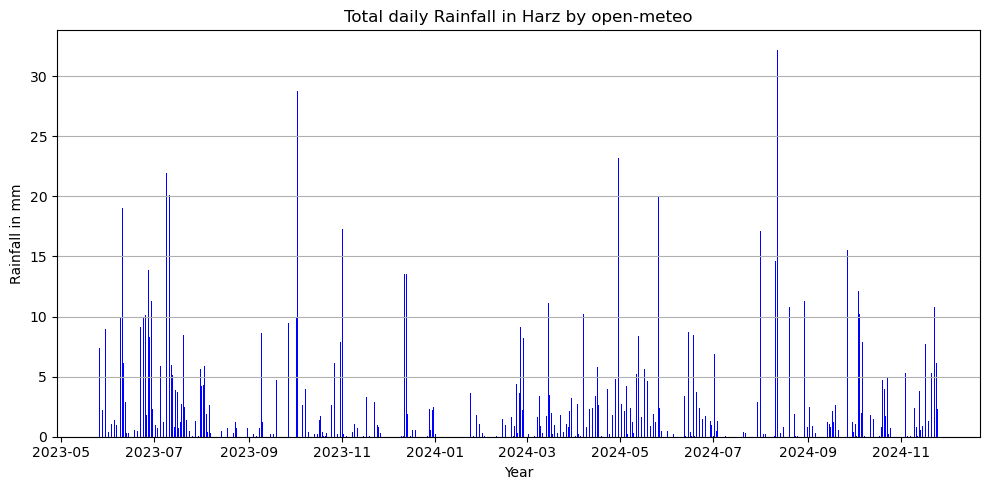

In [79]:
plt.figure(figsize=(10, 5))
plt.bar(daily_dataframe['date'], daily_dataframe['rainfall_sum'], width=0.5, color='blue')
plt.title('Total daily Rainfall in Harz by open-meteo')
plt.xlabel('Year')
plt.ylabel('Rainfall in mm')
plt.grid(axis='y')
plt.tight_layout()

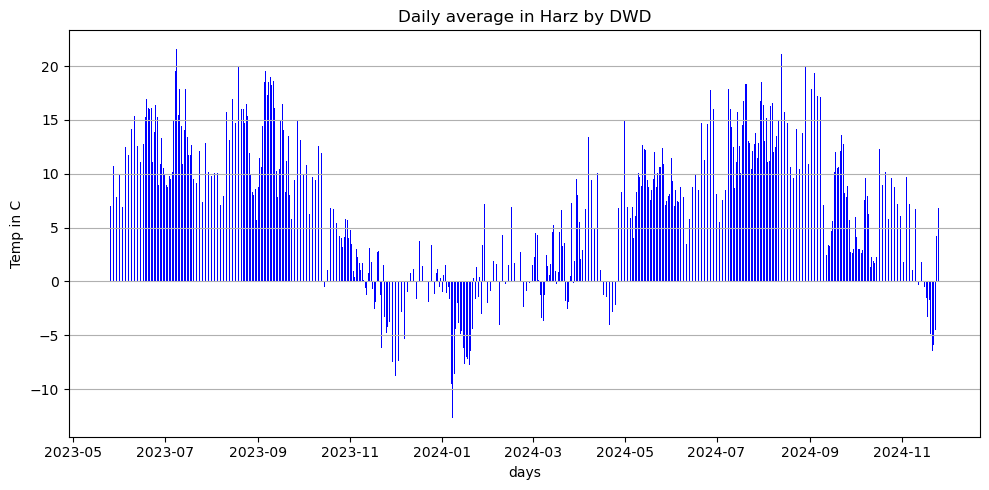

In [80]:
# tempreature data
plt.figure(figsize=(10, 5))
plt.bar(Dwd_daily['date'], Dwd_daily['Daily average temperature'], width=0.5, color='blue')
plt.title('Daily average in Harz by DWD')
plt.xlabel('days')
plt.ylabel('Temp in C')
plt.grid(axis='y')
plt.tight_layout()

In [81]:
# Make sure all required weather variables are listed here
# The order of variables in hourly or daily is important to assign them correctly below
url = "https://climate-api.open-meteo.com/v1/climate"
params = {
	"latitude": [51.79],
	"longitude": [10.62],
	"start_date": "2023-05-26",
	"end_date": "2024-11-25",
	"models": "MRI_AGCM3_2_S",
	"timezone": "Europe/Berlin",
	"disable_bias_correction": "true",
	"daily": "temperature_2m_mean"
}
responses = openmeteo.weather_api(url, params=params)

In [82]:
# Process first location. Add a for-loop for multiple locations or weather models
response = responses[0]
print(f"Coordinates {response.Latitude()}°N {response.Longitude()}°E")
print(f"Elevation {response.Elevation()} m asl")
print(f"Timezone {response.Timezone()} {response.TimezoneAbbreviation()}")
print(f"Timezone difference to GMT+0 {response.UtcOffsetSeconds()} s")

# Process daily data. The order of variables needs to be the same as requested.
daily = response.Daily()
daily_rain_sum = daily.Variables(0).ValuesAsNumpy()

daily_data = {"date": pd.date_range(
    start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
    end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
    freq = pd.Timedelta(seconds = daily.Interval()),
    inclusive = "left"
)}
daily_data["open_meteo_temp"] = daily_rain_sum

daily_Temp_dataframe = pd.DataFrame(data = daily_data)

# Create a DataFrame for the current station
#dataframe[station_key] = daily_dataframe

# Print the DataFrame for the current station (optional)
print(daily_Temp_dataframe)

Coordinates 51.5625°N 10.6875°E
Elevation 992.0 m asl
Timezone None None
Timezone difference to GMT+0 0 s
                         date  open_meteo_temp
0   2023-05-26 00:00:00+00:00        16.200001
1   2023-05-27 00:00:00+00:00        12.950000
2   2023-05-28 00:00:00+00:00        12.550000
3   2023-05-29 00:00:00+00:00        14.300000
4   2023-05-30 00:00:00+00:00        16.299999
..                        ...              ...
545 2024-11-21 00:00:00+00:00         5.850000
546 2024-11-22 00:00:00+00:00         5.550000
547 2024-11-23 00:00:00+00:00         3.850000
548 2024-11-24 00:00:00+00:00         4.450000
549 2024-11-25 00:00:00+00:00         3.200000

[550 rows x 2 columns]


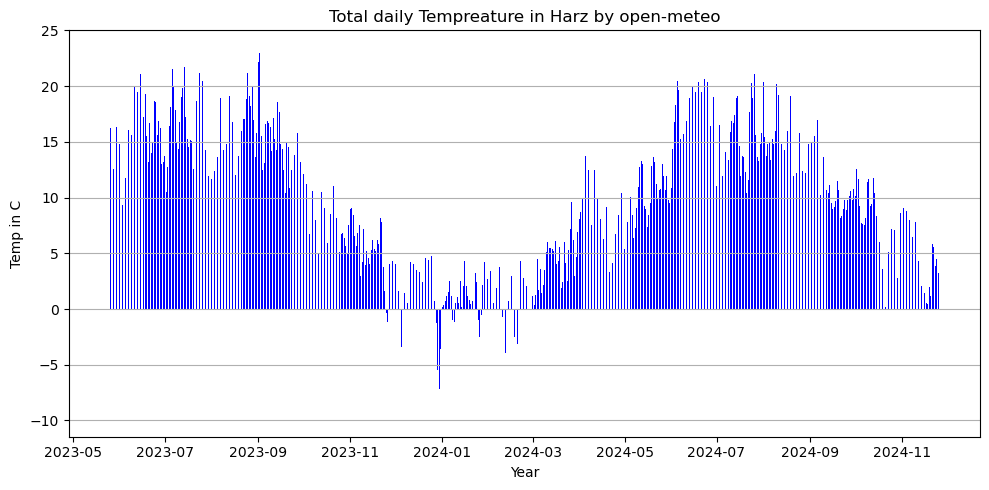

In [83]:
plt.figure(figsize=(10, 5))
plt.bar(daily_Temp_dataframe['date'], daily_Temp_dataframe['open_meteo_temp'], width=0.5, color='blue')
plt.title('Total daily Tempreature in Harz by open-meteo')
plt.xlabel('Year')
plt.ylabel('Temp in C')
plt.grid(axis='y')
plt.tight_layout()

In [84]:
# Calculate metrics
# dwd_temp = dwd_data['temperature'].sel(lat=51.5, lon=11.0).groupby('time.month').mean()
# model_temp = model_data['temperature'].sel(lat=51.5, lon=11.0).groupby('time.month').mean()
daily_Temp_dataframe['dwd_temp_data'] = Dwd_daily['Daily average temperature']


In [85]:
mbe = np.mean( daily_Temp_dataframe['open_meteo_temp'] - daily_Temp_dataframe['dwd_temp_data'])
rmse = np.sqrt(mean_squared_error(daily_Temp_dataframe['dwd_temp_data'], daily_Temp_dataframe['open_meteo_temp']))
correlation = np.corrcoef(daily_Temp_dataframe['dwd_temp_data'], daily_Temp_dataframe['open_meteo_temp'])[0, 1]

# Print results
print(f"Mean Bias Error (MBE): {mbe}")
print(f"Root Mean Square Error (RMSE): {rmse}")
print(f"Correlation: {correlation}")

Mean Bias Error (MBE): 2.896090913582932
Root Mean Square Error (RMSE): 5.498924282639782
Correlation: 0.7448891807249173


In [153]:
# Function for frequent use
def single_open_meteo_data(start_date:str, end_date:str, model:int, lat:list, long:list, variable):
	model_list = {1:"CMCC_CM2_VHR4", 2:"FGOALS_f3_H", 3:"HiRAM_SIT_HR", 4:"MRI_AGCM3_2_S", 5:"EC_Earth3P_HR", 6:"MPI_ESM1_2_XR", 7:"NICAM16_8S"}
	url = "https://climate-api.open-meteo.com/v1/climate"
	params = {
	"latitude": lat,
	"longitude": long,
	"start_date":start_date,
	"end_date": end_date,
	"models": model_list[model],
	"timezone": "Europe/Berlin",
	"disable_bias_correction": "true",
	"daily": variable
	}
	responses = openmeteo.weather_api(url, params=params)
	response = responses[0]
	# Process daily data. The order of variables needs to be the same as requested.
	daily = response.Daily()
	daily_sum = daily.Variables(0).ValuesAsNumpy()

	daily_data = {"date": pd.date_range(
	start = pd.to_datetime(daily.Time(), unit = "s", utc = True),
	end = pd.to_datetime(daily.TimeEnd(), unit = "s", utc = True),
	freq = pd.Timedelta(seconds = daily.Interval()),
	inclusive = "left"
	)}
	daily_data["open_meteo"] = daily_sum

	daily_dataframe = pd.DataFrame(data = daily_data)
	if daily_dataframe.empty:
		return print("The daily limit reached")
	return daily_dataframe

def calculate_accuracy(original_data, predicted_data):
	mbe = np.mean(predicted_data - original_data)
	rmse = np.sqrt(mean_squared_error(original_data, predicted_data))
	correlation = np.corrcoef(original_data, predicted_data)[0, 1]

	# Print results
	print(f"Mean Bias Error (MBE): {mbe}")
	print(f"Root Mean Square Error (RMSE): {rmse}")
	print(f"Correlation: {correlation}")


In [136]:
# For 50 years of data  model = "MRI_AGCM3_2_S"
open_meto_50_years_Temp_dataframe = single_open_meteo_data("1950-01-01", "2023-12-31", 4 ,[51.79], [10.62],"temperature_2m_mean")
open_meto_50_years_Temp_dataframe

,date,open_meteo
0,1950-01-01 00:00:00+00:00,-3.00
1,1950-01-02 00:00:00+00:00,-2.30
2,1950-01-03 00:00:00+00:00,1.15
3,1950-01-04 00:00:00+00:00,4.85
4,1950-01-05 00:00:00+00:00,3.95
...,...,...
27023,2023-12-27 00:00:00+00:00,0.75
27024,2023-12-28 00:00:00+00:00,-1.25
27025,2023-12-29 00:00:00+00:00,-5.45
27026,2023-12-30 00:00:00+00:00,-7.20


In [141]:
is_null = open_meto_50_years_Temp_dataframe.isna().sum()
is_null 

date          0
open_meteo    0
dtype: int64

In [137]:
# Caluculating
calculate_accuracy( Dwd_50_year_data["1950-01-01":"2023-12-31"]["Daily average temperature"],open_meto_50_years_Temp_dataframe["open_meteo"])

Mean Bias Error (MBE): nan
Root Mean Square Error (RMSE): 6.503470026803285
Correlation: nan


In [ ]:
mbe = np.mean( open_meto_50_years_Temp_dataframe["open_meteo"] - Dwd_50_year_data["1950-01-01":"2023-12-31"]["Daily average temperature"])
print(mbe)

nan


In [108]:
print(np.isfinite( open_meto_50_years_Temp_dataframe["open_meteo"]).all())

True


In [113]:
error = open_meto_50_years_Temp_dataframe["open_meteo"] < -30
error.any()

False

In [149]:
# Example data
observed = Dwd_50_year_data["1950-01-01":"2023-12-31"]["Daily average temperature"]  # Replace with your observed data
predicted = open_meto_50_years_Temp_dataframe["open_meteo"]  # Replace with your model data

# Check data alignment
if len(observed) != len(predicted):
    print("Error: Observed and Predicted arrays must have the same length.")

# Calculate residuals
residuals = observed - predicted

# Debug residuals
if np.isnan(residuals).any():
    print("Error: Residuals contain NaN values.")
if np.isinf(residuals).any():
    print("Error: Residuals contain infinite values.")

# Calculate MBE
mbe = np.sum(residuals) / len(observed)

print(f"Mean Bias Error (MBE): {mbe}")

Error: Residuals contain NaN values.
Mean Bias Error (MBE): 0.0


In [150]:
mask = ~np.isnan(observed) & ~np.isnan(predicted)
observed_filtered = observed[mask]
predicted_filtered = predicted[mask]

residuals = observed_filtered - predicted_filtered
mbe = np.sum(residuals) / len(observed_filtered)
print(f"Mean Bias Error (MBE): {mbe}")

print(f"Observed Size: {len(observed)}, Predicted Size: {len(predicted)}")
print(f"Valid Data Points After Mask: {np.sum(mask)}")

Mean Bias Error (MBE): nan
Observed Size: 27028, Predicted Size: 27028
Valid Data Points After Mask: 0


C:\Users\rande\AppData\Local\Temp\ipykernel_24292\2108004006.py:6: RuntimeWarning: invalid value encountered in scalar divide
  mbe = np.sum(residuals) / len(observed_filtered)


In [151]:
#model_list = {1:"CMCC_CM2_VHR4", 2:"FGOALS_f3_H", 3:"HiRAM_SIT_HR", 4:"MRI_AGCM3_2_S", 5:"EC_Earth3P_HR", 6:"MPI_ESM1_2_XR", 7:"NICAM16_8S"}
list_model = ["CMCC_CM2_VHR4", "FGOALS_f3_H", "HiRAM_SIT_HR", "MRI_AGCM3_2_S", "EC_Earth3P_HR", "MPI_ESM1_2_XR", "NICAM16_8S"]

In [ ]:
#For TempreatureCMCC_CM2_VHR4
for i in [1,2,3,4,5,6,7]:
    print("/n")
    print("Calculationg Accuracy for mode for Tempreatures, ",list_model[i-1])
    open_meto_50_years_Temp_dataframe_4 = single_open_meteo_data("2013-01-01", "2023-12-31", i ,[51.8], [10.62],"temperature_2m_mean")
    calculate_accuracy( Dwd_50_year_data["2013-01-01":"2023-12-31"]["Daily average temperature"],open_meto_50_years_Temp_dataframe_4["open_meteo"])

/n
Calculationg Accuracy for mode for Tempreatures,  CMCC_CM2_VHR4
Mean Bias Error (MBE): nan
Root Mean Square Error (RMSE): 7.259850210395349
Correlation: 0.7250409444804369
/n
Calculationg Accuracy for mode for Tempreatures,  FGOALS_f3_H
Mean Bias Error (MBE): nan
Root Mean Square Error (RMSE): 7.796503854825057
Correlation: 0.6250133297815945
/n
Calculationg Accuracy for mode for Tempreatures,  HiRAM_SIT_HR
Mean Bias Error (MBE): nan
Root Mean Square Error (RMSE): 6.789819353846148
Correlation: 0.6938737263422272
/n
Calculationg Accuracy for mode for Tempreatures,  MRI_AGCM3_2_S
Mean Bias Error (MBE): nan
Root Mean Square Error (RMSE): 6.011696864400487
Correlation: 0.7254147867974609
/n
Calculationg Accuracy for mode for Tempreatures,  EC_Earth3P_HR
Mean Bias Error (MBE): nan
Root Mean Square Error (RMSE): 6.54548518717258
Correlation: 0.6955677819291175
/n
Calculationg Accuracy for mode for Tempreatures,  MPI_ESM1_2_XR
Mean Bias Error (MBE): nan
Root Mean Square Error (RMSE): 7.62

In [159]:
#For "precipitation_sum"
for i in [3,4,5,6,7]:
    print("/n")
    print("Calculationg Accuracy for mode for rain_sum, ",list_model[i-1])
    open_meto_50_years_Temp_dataframe_4 = single_open_meteo_data("1950-01-01", "2023-12-31", i ,[51.8], [10.62],"rain_sum")
    calculate_accuracy( Dwd_50_year_data["1950-01-01":"2023-12-31"]["daily rainfall"],open_meto_50_years_Temp_dataframe_4["open_meteo"])

/n
Calculationg Accuracy for mode for rain_sum,  HiRAM_SIT_HR
Mean Bias Error (MBE): nan
Root Mean Square Error (RMSE): 9.698383692147864
Correlation: -0.0023089647406337073
/n
Calculationg Accuracy for mode for rain_sum,  MRI_AGCM3_2_S
Mean Bias Error (MBE): nan
Root Mean Square Error (RMSE): 9.511795682221466
Correlation: 0.010557581148481533
/n
Calculationg Accuracy for mode for rain_sum,  EC_Earth3P_HR
Mean Bias Error (MBE): nan
Root Mean Square Error (RMSE): 9.214066455208838
Correlation: -0.013362444395800822
/n
Calculationg Accuracy for mode for rain_sum,  MPI_ESM1_2_XR
Mean Bias Error (MBE): nan
Root Mean Square Error (RMSE): 9.250994408557387
Correlation: -0.004529138224413996
/n
Calculationg Accuracy for mode for rain_sum,  NICAM16_8S
Mean Bias Error (MBE): nan
Root Mean Square Error (RMSE): 9.782414862905245
Correlation: 0.0032536083633152215
